# In-Depth Tutorial to spaCy For Beginners
![](images/pexels.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/photo/red-blue-and-white-fluid-abstract-painting-2317710/'>Anni Roenkae</a>
    </strong>
</figcaption>


### Introduction

No, we won't be building language models with billions of parameters today. We will start smaller and learn about the basics of NLP with spaCy. We will take a close look at how the library works and how you can use it to solve beginner/medium NLP problems with ease.

The post is already long, so I'll cut it here and jump to the meat of the article.

### What is spaCy?

### Basics of spaCy

Before seeing how spaCy works, let's install it with its contents for the English language:

```bash
pip install -U spacy
```

spaCy has three pipelines for English, with varying sizes and functionality for complex tasks. In this tutorial, we will only need to install the small and medium pipelines but I am including the large one as well for completeness:

```bash
python -m spacy download en_core_web_sm  # 12 MB
python -m spacy download en_core_web_md  # 31 MB
python -m spacy download en_core_web_lg  # 382 MB
```

After importing spaCy, we need to load one of the pipelines we just installed. For now, we will load the small one and store it to `nlp`:

In [1]:
import spacy

txt = "The tallest living man is 37-year-old Sultan Kosen, from Turkey, who is 8 feet, 2.8 inches, who set the record in 2009."

# Create the Language object
nlp = spacy.load("en_core_web_sm")
nlp

It is a convention to name any loaded language models `nlp` in the spaCy ecosystem. This object can now be called on any text to start information extraction:

In [2]:
# Create the Doc object
doc = nlp(txt)

The `doc` object is also a convention and now it is already filled with extra information about the sentences and their words. 

In general, the `doc` object is just an iterator:

In [3]:
for token in doc[:5]:
    print(token)

The
tallest
living
man
is


You can use slicing or indexing notations to extract individual tokens: 

In [4]:
type(token)

spacy.tokens.token.Token

In [5]:
len(doc)

31

If you extract more than one token, then you have a span object:

In [6]:
span = doc[:5]
type(span)

spacy.tokens.span.Span

In [7]:
span.text

'The tallest living man is'

spaCy is also built for memory efficiency. That's why both `token` and `span` objects are just views of the `doc` object. There is no duplication. 

The pre-trained English pipeline and many other pipelines come with language-specific rules for tokenization and extracting their lexical attributes. Here are 6 of such attributes:

> Tokenization simply means splitting sentences into words and punctuation.



In [8]:
print("Index:    ", [token.i for token in doc[3:10]])
print("Text:     ", [token.text for token in doc[3:10]])
print("is_alpha: ", [token.is_alpha for token in doc[3:10]])
print("is_punct: ", [token.is_punct for token in doc[3:10]])
print("like_num: ", [token.like_num for token in doc[3:10]])
print("Base word:", [token.lemma_ for token in doc[3:10]])

Index:     [3, 4, 5, 6, 7, 8, 9]
Text:      ['man', 'is', '37', '-', 'year', '-', 'old']
is_alpha:  [True, True, False, False, True, False, True]
is_punct:  [False, False, False, True, False, True, False]
like_num:  [False, False, True, False, False, False, False]
Base word: ['man', 'be', '37', '-', 'year', '-', 'old']


Some interesting attributes are `lemma_`, which returns the base word stripped from any suffixes, prefixes, tense or any other grammatical attributes, and the `like_num` which recognizes both literal and lettered numbers. 

You will be spending most of your time on these four objects - `nlp`, `doc`, `token` and `span`. Let's take a closer look at how they are related.

### Architecture and core data structures

Let's start again with the `nlp`, which is a Language object under the hood:

In [9]:
import spacy

nlp = spacy.load("en_core_web_md")

type(nlp)

spacy.lang.en.English

Language objects are pre-trained on millions of text instances and labels and loaded into spaCy with their binary weights. These weights allows you to perform a rich variety of tasks on new datasets without worrying about the hairy details. 

As I mention earlier, spaCy has fully-trained pipelines for 22 languages, some of which you can see below:

```python
nlp = spacy.load("es_core_news_sm")  # Spanish
nlp = spacy.load("ru_core_news_sm")  # Russian
nlp = spacy.load("zh_core_web_sm")  # Chinese
nlp = spacy.load("de_core_news_sm")  # German
```

For other +40 languages, spaCy only offers basic tokenization rules and other functionality is being slowly integrated with community effort.

It is also possible to load the language models directly from the `lang` sub-module:

In [10]:
from spacy.lang.en import English
from spacy.lang.es import Spanish

nlp = English()

type(nlp)

spacy.lang.en.English

In [11]:
txt = """The original name for the search engine Google was Backrub. 
         It was renamed Google after the googol, 
         which is the number one followed by 100 zeros."""

doc = nlp(txt)

After processing a text, words and punctuation are stored into the vocabulary object of `nlp`:

In [12]:
type(nlp.vocab)

spacy.vocab.Vocab

This `Vocab` is shared between documents, meaning it stores all new words from all docs. In contrast, the `doc` object's vocabular only contains the words from the `txt`:

In [13]:
type(doc.vocab)

spacy.vocab.Vocab

Internally, spaCy communicates in hashes to save memory and has a two-way look-up table called `StringStore`. You can get the hash of a string or get the string if you have the hash:

In [14]:
type(nlp.vocab.strings)

spacy.strings.StringStore

In [15]:
nlp.vocab.strings["google"]

1988622737398120358

In [16]:
nlp.vocab.strings[1988622737398120358]

'google'

When tokens go into the `Vocab`, they loose all their context-specific information. So, when you look up words from the vocab, you are looking up `lexeme`s:

In [17]:
lexeme = nlp.vocab["google"]

type(lexeme)

spacy.lexeme.Lexeme

Lexemes don't contain context specific information like part-of-speech tags, morphological dependencies, etc. But they still offer many lexical attributes of the word:

In [18]:
print(lexeme.text, lexeme.orth, lexeme.is_digit)

google 1988622737398120358 False


> `orth` attribute is for the hash of the lexeme.

So, in short, if you are looking at a word through the `doc` object, it is a token. If it is from a `Vocab`, it is a lexeme.

Now, let's talk more about the `doc` object.

In [19]:
txt = """Mosquitoes are the deadliest animal in the world: 
         They kill more people than any other creature, 
         due to the diseases they carry."""

doc = nlp(txt)

type(doc)

spacy.tokens.doc.Doc

It is automatically generated when you call `nlp` on text and has its own attributes:

In [20]:
doc.text

'Mosquitoes are the deadliest animal in the world: \n         They kill more people than any other creature, \n         due to the diseases they carry.'

In [21]:
len(doc)

27

You can create them manually as well, by importing the `Doc` class from `tokens` module:

In [22]:
from spacy.lang.en import English
from spacy.tokens import Doc

nlp = English()

words = ["I", "love", "Barcelona", "!"]
spaces = [True, True, False, False]

# Create the doc object manually
doc = Doc(nlp.vocab, words=words, spaces=spaces)

`Doc` requires three arguments - the vocabulary from `nlp`, a list of words and another list specifying if the words are folled by a space (including the last one). All tokes in `doc` have this information.

In [23]:
len(doc)

4

In [24]:
doc.text

'I love Barcelona!'

Spans are also a class of their own and expose a range of attributes, even though they are just a view of the `doc` object:

In [25]:
txt = """The hardest working muscle in your body is your heart: 
         It pumps more than 2,000 gallons of blood a day
         and beats more than 2.5 billion times in a 70-year life span."""

doc = nlp(txt)

span = doc[:10]

type(span)

spacy.tokens.span.Span

In [26]:
print(span.text)
print(span.start, span.end)

The hardest working muscle in your body is your heart
0 10


To create the Span objects manually, pass the doc object and start/end indices of the tokens to the `Span` class:

In [27]:
from spacy.tokens import Span

span = Span(doc, 0, 10)
span.text

'The hardest working muscle in your body is your heart'

### Named Entity Recognition (NER)

One of the most common tasks in NLP is predicting named entities, like people, locations, countries, brands, etc. 

Performed NER is ridiculously easy in spaCy. After processing a text, just extract the `ents` attribute of the `doc` object:

In [56]:
txt = """Cleopatra wasn’t actually Egyptian! 
         As far as historians can tell, Egypt’s 
         famous femme fatal was actually Greek!. 
         She was a descendant of Alexander the Great’s
         Macedonian general Ptolemy"""

nlp = spacy.load("en_core_web_md")

doc = nlp(txt)

In [57]:
for ent in doc.ents:
    print(f"{ent.text:<20}{ent.label_:<20}")

Cleopatra           PERSON              
Egyptian            NORP                
Egypt               GPE                 
Greek               NORP                
Macedonian          NORP                
Ptolemy             PERSON              


Cleopatra is recognized as PERSON, while Egypt is a Geo-political entity (GPE). To know the meaning for other labels, you can use the `explain` function:

In [58]:
spacy.explain("GPE")

'Countries, cities, states'

In [59]:
spacy.explain("NORP")

'Nationalities or religious or political groups'

Instead of printing text, you can use spaCy's visual entity tagger, available via `displacy`:

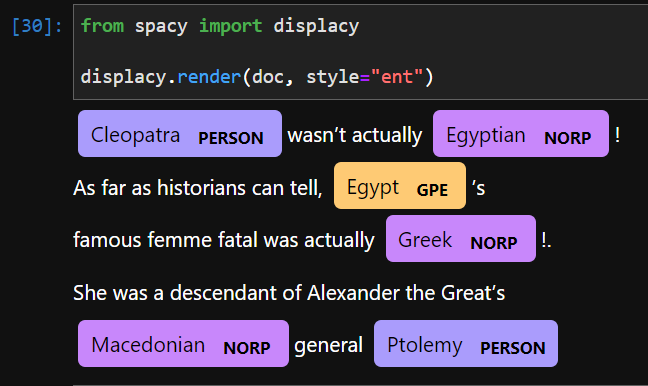

From the image, we can see that Alexander the Great isn't recognized as PERSON because it is not a common name. But no matter, we can label Alexander as PERSON manually.

First, extract the full name as a span, by giving it a label (PERSON):

In [60]:
from spacy.tokens import Span

alexander = Span(doc, 31, 34, label="PERSON")
alexander

Alexander the Great

Then, updated the `ents` list with the span:

In [61]:
doc.ents = list(doc.ents) + [alexander]

Now, `displacy` tags it as well:

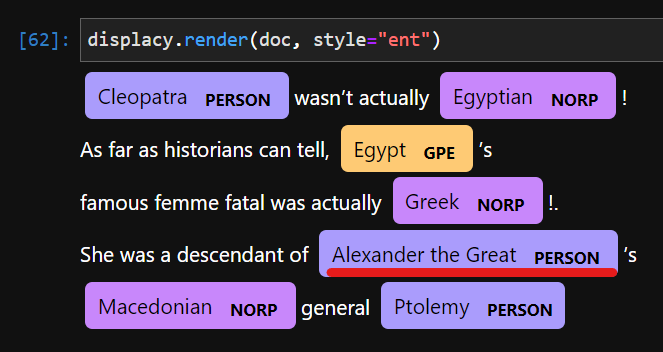

You could've set the new entity with `set_ents` function as well:

```python
# Leaves the rest of ents untouched
doc.set_ents([alexander], default="unmodified")
```

### Predicting part-of-speech (POS) tags and syntactic dependencies

In [35]:
txt = "The first footprints on the moon will remain there for a million years"

doc = nlp(txt)

for token in doc:
    print(f"{token.text:<20} {token.pos_:<20} {token.dep_:<20}")

The                  DET                  det                 
first                ADJ                  amod                
footprints           NOUN                 nsubj               
on                   ADP                  prep                
the                  DET                  det                 
moon                 NOUN                 pobj                
will                 AUX                  aux                 
remain               VERB                 ROOT                
there                ADV                  advmod              
for                  ADP                  prep                
a                    DET                  quantmod            
million              NUM                  nummod              
years                NOUN                 pobj                


In [36]:
pos_tags = ["DET", "AUX", "ADP"]
dep_tags = ["amod", "nsubj", "nummod"]

for pos in pos_tags:
    print(pos, "-->", spacy.explain(pos))

for dep in dep_tags:
    print(dep, "-->", spacy.explain(dep))

DET --> determiner
AUX --> auxiliary
ADP --> adposition
amod --> adjectival modifier
nsubj --> nominal subject
nummod --> numeric modifier


In [37]:
displacy.render(doc, style="dep")

In [38]:
txt = """The teddy bear is named after President Theodore Roosevelt. 
         After he refused to shoot a captured black bear on a hunt, 
         a stuffed-animal maker decided to create
         a bear and name it after the president."""

doc = nlp(txt)

for chunk in doc.noun_chunks:
    print(chunk.text)

The teddy bear
President Theodore Roosevelt
he
a captured black bear
a hunt
a stuffed-animal maker
a bear
it
the president


### Custom rule-based tokenization

In [39]:
txt = """Cleopatra wasn’t actually Egyptian! 
         As far as historians can tell, Egypt’s 
         famous femme fatal was actually Greek!. 
         She was a descendant of Alexander the Great’s
         Macedonian general Ptolemy"""

# Create a pattern
pattern = [
    {"IS_ALPHA": True, "IS_TITLE": True},
    {"IS_STOP": True},
    {"IS_ALPHA": True, "IS_TITLE": True},
]

In [40]:
from spacy.matcher import Matcher

# Init the matcher with the shared vocab
matcher = Matcher(nlp.vocab)

# Add the pattern to the matcher
matcher.add("TITLED_PERSON", [pattern])

# Process the text
doc = nlp(txt)

# Find all matches
matches = matcher(doc)

# Iterate over matches
for match_id, start, end in matches:
    # Get the span
    span = doc[start:end]
    print(span.text)

Alexander the Great


In [41]:
pattern = [
    {"TEXT": {"REGEX": "[a-zA-Z]+"}},
    {"IS_DIGIT": True, "OP": "?"},  # Match one or more times
    {"DEP": "quantmod"},  # Match based on dependency
    # etc.
]

### Word vectors and semantic similarity

In [42]:
nlp = spacy.load("en_core_web_md")

doc1 = nlp("What a lukeworm sentiment.")
doc2 = nlp("What a short sentence.")

doc1.similarity(doc2)

0.9200780919749721

In [43]:
doc1[-1].similarity(doc2[2])

0.5222234129905701

In [44]:
doc1[0:2].similarity(doc[3])

0.8700238466262817

In [45]:
array = doc1[0].vector

array.shape

(300,)

### All about pipelines

In [46]:
nlp = spacy.load("en_core_web_sm")

nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [47]:
from spacy.language import Language


@Language.component("your_component")
def your_component(doc):
    # Do something on the doc
    print(f"There are {len(doc)} tokens in this text.")

    return doc

In [48]:
nlp.add_pipe("your_component")

<function __main__.your_component(doc)>

In [49]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'your_component']

In [50]:
doc = nlp("Bird dies, but you remember the flight.")

There are 9 tokens in this text.


In [51]:
from spacy.language import Language
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")


@Language.component("titled_person")
def titled_person(doc):
    pattern = [
        {"IS_ALPHA": True, "IS_TITLE": True},
        {"IS_STOP": True},
        {"IS_ALPHA": True, "IS_TITLE": True},
    ]
    # Create the matcher
    matcher = Matcher(doc.vocab)
    # Add the pattern
    matcher.add("TITLED_PERSON", [pattern])

    matches = matcher(doc)
    matched_spans = [Span(doc, start, end) for _, start, end in matches]

    # Add the matched spans to doc's entities
    doc.ents = list(doc.ents) + matched_spans

    return doc


nlp.add_pipe("titled_person")

<function __main__.titled_person(doc)>

In [52]:
txt = """Cleopatra wasn’t actually Egyptian! 
         As far as historians can tell, Egypt’s 
         famous femme fatal was actually Greek!. 
         She was a descendant of Alexander the Great’s
         Macedonian general Ptolemy"""

doc = nlp(txt)

nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'titled_person']

### Setting custom extensions (metadata)

### Conclusion